# SETRED
The idea of rewriting the code of the repository is to get a coomprhensive understanding of the SETRED method. 

SETRED stands for self-training with Editing. 

Create a SETRED classifier. It is a self-training algorithm that uses a rejection mechanism to avoid adding noisy samples to the training set. 

The main process are:
1. Train a classifier with the labeled data
2. Create a pool of unalbeled data and select the most confident predictions. 
3. Repeat until the maximum number of iterations is reached. 

    - a. Select the most confident predictions from the unlabeled data. 
    - b. Calculate the neighborhood graph of the labeled data and the selected instances from the unlabeled data. 
    - c. Calculate the significance level of the selected instances (Statistic J_i, sum of cut edges )
    - d. Reject the instances that are not significant according to the statistics J_i.
    - e. Add the selected instances to the labeled data and retrain the classifier. 
    - f. Add new instances to the pool of unalabeled data. 
    
4. Return the classifier trained with the labeled data. 




In [1]:
# Common libraries
import numpy as np 
import pandas as pd 
from scipy.stats import norm 
import os

# Sklearn libraries
# BaseEstimator is a helper class provided by scikit-learn to make it easier to create your own custom models or transformers that behave like 
# any other scikit-learn model. 
# MetaEstimatorMixin is a mixin class from sksklearn.base to help create meta-estimators, which are estimators that wrap other estimators.
from sklearn.base import BaseEstimator, MetaEstimatorMixin, ClassifierMixin
# The clone function creates a new copy of an estimator with the same parameters, but without any trained data, without any fitted attributes. 
from sklearn.base import clone as skclone 
from sklearn.base import is_classifier
from sklearn.ensemble._base import _set_random_states

# Models
from sklearn.neighbors import KNeighborsClassifier, kneighbors_graph
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree
from sklearn.semi_supervised import SelfTrainingClassifier

# Utils
from sklearn.utils import check_random_state, resample
from sklearn.utils import check_X_y, check_array
from sklearn.utils.validation import check_is_fitted
from sklearn.utils.metaestimators import available_if

# Selection classifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

# Evaluation metrics
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    auc,
    confusion_matrix,
    classification_report,
    roc_curve,
    precision_recall_curve,
    log_loss)

from sklearn.metrics import classification_report

# Simulation functions
from sklearn.datasets import make_classification, make_blobs
from adspy_shared_utilities import plot_class_regions_for_classifier

# Visualization libraries
import seaborn as sn
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import matplotlib.colors as mcolors

# Data
from sklearn.datasets import load_iris

# SSlearn library
from sslearn.utils import calculate_prior_probability, check_classifier
from sslearn.model_selection import artificial_ssl_dataset
from sslearn.wrapper import Setred

In [2]:
from setred_package import Setred_scratch, simulated_data

# Simulation

The simulation consists of:

- n: 13000 intances
- classes: 5 labels
- X: design matrix

In [3]:
X = np.load("data/X.npy")
y = np.load("data/y.npy")
X_unlabel = np.load("data/X_unlabel.npy")
y_unlabel = np.load("data/y_unlabel.npy")
X_ori = np.load("data/X_ori.npy")
y_ori = np.load("data/y_ori.npy")
X_test = np.load("data/X_test.npy")
y_test = np.load("data/y_test.npy")

In [4]:
cmap_bold = ListedColormap(colors = [
    '#FF0000',  # Red
    '#00FF00',  # Lime Green
    '#0000FF',  # Blue
    '#800080',  # Purple
    '#00FFFF',  # Cyan / Aqua
    '#FFC0CB',  # Pink
    '#808080',  # Gray
    '#A52A2A',  # Brown
])

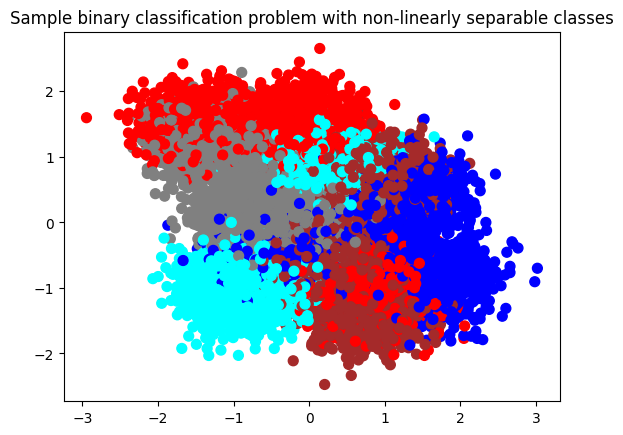

In [5]:
plt.figure()
plt.title('Sample binary classification problem with non-linearly separable classes')
plt.scatter(X_ori[:,0], X_ori[:,1], c=y_ori,
           marker= 'o', s=50, cmap=cmap_bold)
plt.show()

## Generation of artificial semisupervised learning


In [6]:
# Print the shape of the datasets
print(f"Shape of X: {X.shape}, y: {y.shape}, X_unlabel: {X_unlabel.shape}, y_unlabel: {y_unlabel.shape}")
# Print the number of the classes in y
print(f"Frequencies of classes in y: {pd.Series(y).value_counts(normalize=False)}")


Shape of X: (9750, 2), y: (9750,), X_unlabel: (9653, 2), y_unlabel: (9653,)
Frequencies of classes in y: -1    9653
 1      27
 3      21
 0      19
 2      17
 4      13
Name: count, dtype: int64


In [7]:
# Filtering the labeled instances
X_val = X[y != -1]
y_val = y[y != -1]
# Print the shape of the validation and testing sets
print(f"Shape of X_val: {X_val.shape}, y_val: {y_val.shape}, X_test: {X_test.shape}, y_test: {y_test.shape}")
# Print the number of the classes in y_val and y_test
print(f"Frequencies of classes in y_val: {pd.Series(y_val).value_counts(normalize=False)}")
print(f"Frequencies of classes in y_test: {pd.Series(y_test).value_counts(normalize=False)}")


Shape of X_val: (97, 2), y_val: (97,), X_test: (3250, 2), y_test: (3250,)
Frequencies of classes in y_val: 1    27
3    21
0    19
2    17
4    13
Name: count, dtype: int64
Frequencies of classes in y_test: 4    677
3    661
0    639
2    638
1    635
Name: count, dtype: int64


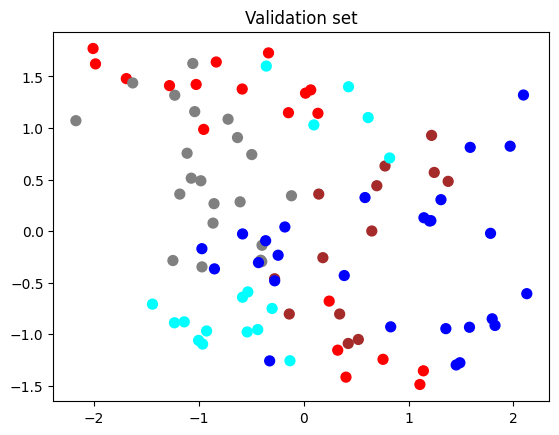

In [8]:
plt.figure()
plt.title('Validation set')
plt.scatter(X_val[:,0], X_val[:,1], c=y_val,
           marker= 'o', s=50, cmap=cmap_bold)
plt.show()

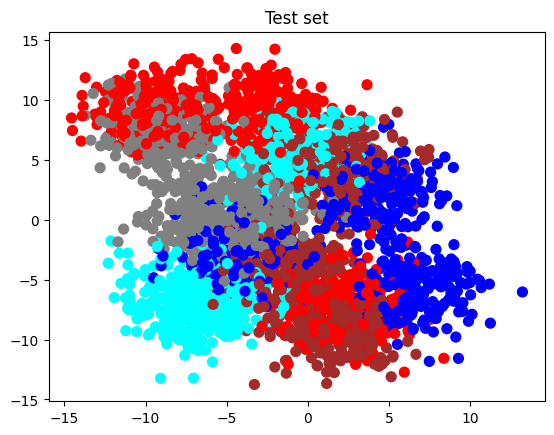

In [9]:
plt.figure()
plt.title('Test set')
plt.scatter(X_test[:,0], X_test[:,1], c=y_test,
           marker= 'o', s=50, cmap=cmap_bold)
plt.show()

In [10]:
X_test.shape[0]

3250

# Decision Tree

- Hyperparamter tunning with the validation data
- Check the performance of the classifier on the test data

In [11]:
# Fitting a decision tree with hyperparameters tunning using cross validation
dt = DecisionTreeClassifier(random_state=42)
param_grid = {
    'max_depth': [None, 5, 10, 15],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}


grid_search = GridSearchCV(dt, param_grid, cv=5)
print("The shape of X_val:", X_val.shape)
print("The shape of y_val:", y_val.shape)

grid_search.fit(X_val, y_val)

# Best parameters
best_params = grid_search.best_params_
print("Best parameters:", best_params)

# Base estimator
base_estimator_dt = DecisionTreeClassifier(**best_params, random_state=42)

The shape of X_val: (97, 2)
The shape of y_val: (97,)
Best parameters: {'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 2}


In [12]:
# Fit the base estimator on the validation set
dt_fitted = base_estimator_dt.fit(X_val, y_val)

In [13]:
# Print the accuracy of the base estimator on the validation set
y_val_pred = base_estimator_dt.predict(X_val)
y_test_pred = base_estimator_dt.predict(X_test)
# Print the accuracy of the base estimator on the validation set
print(f"Accuracy of the base estimator on the validation set: {accuracy_score(y_val, y_val_pred)}")
print(f"Accuracy of the base estimator on the test set: {accuracy_score(y_test, y_test_pred)}")
# Classification report
from sklearn.metrics import classification_report
print("Classification report on validation set:")
print(classification_report(y_val, y_val_pred))
print("Classification report on test set:")
print(classification_report(y_test, y_test_pred))

Accuracy of the base estimator on the validation set: 0.8350515463917526
Accuracy of the base estimator on the test set: 0.4470769230769231
Classification report on validation set:
              precision    recall  f1-score   support

           0       0.85      0.89      0.87        19
           1       0.87      0.74      0.80        27
           2       1.00      0.82      0.90        17
           3       0.78      0.86      0.82        21
           4       0.71      0.92      0.80        13

    accuracy                           0.84        97
   macro avg       0.84      0.85      0.84        97
weighted avg       0.85      0.84      0.84        97

Classification report on test set:
              precision    recall  f1-score   support

           0       0.41      0.69      0.51       639
           1       0.43      0.64      0.51       635
           2       0.44      0.71      0.54       638
           3       0.81      0.21      0.34       661
           4       0.52 

In [14]:
# Predict the instances that are not labeled with the base estimator
y_unlabel_pred = base_estimator_dt.predict(X_unlabel)
# Print the accuracy of the base estimator on the unlabeled set
print(f"Accuracy of the base estimator on the unlabeled set: {accuracy_score(y_unlabel, y_unlabel_pred)}")
# Print the classification report on the unlabeled set
print("Classification report on unlabeled set:")
print(classification_report(y_unlabel, y_unlabel_pred))


Accuracy of the base estimator on the unlabeled set: 0.5857246451880245
Classification report on unlabeled set:
              precision    recall  f1-score   support

           0       0.55      0.59      0.57      1942
           1       0.59      0.55      0.57      1938
           2       0.68      0.68      0.68      1945
           3       0.70      0.64      0.67      1918
           4       0.43      0.47      0.45      1910

    accuracy                           0.59      9653
   macro avg       0.59      0.59      0.59      9653
weighted avg       0.59      0.59      0.59      9653



# SETRED CLASSIFIER

In [15]:
import warnings
from sklearn.exceptions import UndefinedMetricWarning
warnings.filterwarnings("ignore", category=RuntimeWarning)
warnings.filterwarnings("ignore", category=UndefinedMetricWarning)

# Decision Tree

In [24]:
# Fitting the Setred classifier
ssl_clf_dt = Setred_scratch(base_estimator=base_estimator_dt,
                         max_iterations=2,
                         graph_neighbors=20,                        
                         htunning=True,
                         param_grid={
                                'max_depth': [None, 5, 10, 15],
                                'min_samples_split': [2, 5, 10],
                                'min_samples_leaf': [1, 2, 4]
                            },
                        X_label_real=X_test,
                        y_label_real=y_test,
                        view = 1)
ssl_clf_dt.fit(X, y)


Iteration 1 - 97 labeled instances, 9653 unlabeled instances left
              precision    recall  f1-score   support

           0       0.41      0.69      0.51       639
           1       0.43      0.64      0.51       635
           2       0.44      0.71      0.55       638
           3       0.82      0.23      0.36       661
           4       0.50      0.02      0.04       677

    accuracy                           0.45      3250
   macro avg       0.52      0.46      0.39      3250
weighted avg       0.52      0.45      0.39      3250

Iteration 2 - 182 labeled instances, 9568 unlabeled instances left
              precision    recall  f1-score   support

           0       0.41      0.69      0.52       639
           1       0.40      0.65      0.50       635
           2       0.44      0.71      0.54       638
           3       0.79      0.13      0.23       661
           4       0.55      0.02      0.03       677

    accuracy                           0.43      325

Setred_scratch(X_label_real=array([[ 5.48569129, -7.46427316],
       [-8.2464149 ,  0.82705718],
       [ 7.6760714 , -4.25382174],
       ...,
       [ 3.86573752, -1.2157262 ],
       [-3.62345469, -4.03134377],
       [-4.95973615, -3.65487079]]),
               base_estimator=DecisionTreeClassifier(max_depth=5,
                                                     random_state=42),
               graph_neighbors=20, htunning=True, max_iterations=2,
               param_grid={'max_depth': [None, 5, 10, 15],
                           'min_samples_leaf': [1, 2, 4],
                           'min_samples_split': [2, 5, 10]},
               view=1, y_label_real=array([1, 3, 1, ..., 0, 1, 2]))

# Evaluation Metric

In [17]:
# Generate predictions on the test set
y_pred = ssl_clf_dt.predict(X_test)
# Generate the classification report
print("Classification report on test set after Setred:")
report = classification_report(y_test, y_pred)
print(report)

Classification report on test set after Setred:
              precision    recall  f1-score   support

           0       0.43      0.61      0.50       639
           1       0.32      0.88      0.47       635
           2       0.24      0.17      0.20       638
           3       0.84      0.16      0.27       661
           4       0.47      0.03      0.06       677

    accuracy                           0.36      3250
   macro avg       0.46      0.37      0.30      3250
weighted avg       0.46      0.36      0.30      3250



In [23]:
# Generate predictions on the test set
y_pred = base_estimator_dt.predict(X_test)
# Generate the classification report
print("Classification report on test set after Setred:")
report = classification_report(y_test, y_pred)
print(report)

Classification report on test set after Setred:
              precision    recall  f1-score   support

           0       0.41      0.69      0.51       639
           1       0.43      0.64      0.51       635
           2       0.44      0.71      0.54       638
           3       0.81      0.21      0.34       661
           4       0.52      0.02      0.04       677

    accuracy                           0.45      3250
   macro avg       0.52      0.45      0.39      3250
weighted avg       0.52      0.45      0.39      3250



In [20]:
# Generate predictions on the test set
y_pred = base_estimator_dt.predict(X_unlabel)
y_pred = ssl_clf_dt._base_estimator.predict(X_unlabel)
# Generate the classification report
print("Classification report on test set after Setred:")
report = classification_report(y_unlabel, y_pred)
print(report)

Classification report on test set after Setred:
              precision    recall  f1-score   support

           0       0.34      0.30      0.32      1942
           1       0.74      0.48      0.58      1938
           2       0.42      0.86      0.57      1945
           3       0.58      0.04      0.07      1918
           4       0.20      0.28      0.24      1910

    accuracy                           0.39      9653
   macro avg       0.46      0.39      0.35      9653
weighted avg       0.46      0.39      0.36      9653



# Comparison between the trees

In [ ]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt



In [ ]:
plot_tree(base_estimator_dt, feature_names=["f1", "f2"], class_names=["A", "B","C","D","E"], filled=True)
plt.show()

In [ ]:
plot_tree(ssl_clf_dt._base_estimator, feature_names=["f1", "f2"], class_names=["A", "B","C","D","E"], filled=True)
plt.show()